## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyzotero import zotero

## Construct data

A personal API key has to be used here to make the following code work. Currently, API keys are limited to the owners of the database, to which public access is not provided.

In [2]:
API_KEY = ""

# Get database
zot = zotero.Zotero(2425412, "group", API_KEY)
database_raw = zot.everything(zot.items())

# Extract top level items (articles)
database = [item for item in database_raw if 
            ('parentItem' not in item['data']) and 
            (item['data']['itemType'] != 'note')
           ]

In [3]:
# Function to extract year from diferent date formats
def extract_numbers(string):
    number_list = []
    current_index = 0
    current_number = ''
    at_number = False
    while current_index < len(string):
        if string[current_index] in ['0','1','2','3','4','5','6','7','8','9']:
            current_number += string[current_index]
            at_number = True
        elif at_number == True:
            number_list.append(int(current_number))
            current_number = ''
            at_number = False
        current_index += 1

    # Catch if number at the end
    if at_number == True:
        number_list.append(int(current_number))
    return number_list

# Construct dataframe of relevant information
df_dict = {'key':[], 'title':[], 'date':[], 'tag_color':[], 'tag1':[], 'tag2':[], 'tag3':[]}
for i,item in enumerate(database):
    df_dict['key'].append(item['key'])
    df_dict['title'].append(item['data']['title'])
    
    # Parse date
    current_date_raw = item['data']['date']
    if current_date_raw[:4] not in [str(1950+k) for k in range(80)]:
        current_date_parsed = extract_numbers(current_date_raw)
        position = 0
        while current_date_parsed[position] < 1950:
            position += 1
        df_dict['date'].append(current_date_parsed[position])
    else:
        df_dict['date'].append(int(current_date_raw[:4]))
    
    # Sort tags
    current_tags = item['data']['tags']
    t1, t2, t3 = [],[],[]
    check = True
    for tag in current_tags:
        if tag['tag'][0] == '1':
            t1.append(tag['tag'])
        elif tag['tag'][0] == '2':
            t2.append(tag['tag'])
        elif tag['tag'][0] == '3':
            t3.append(tag['tag'])
        else:
            assert check, 'Warning: More than one unnumbered tag in item with title \''+item['data']['title']+'\''
            df_dict['tag_color'].append(tag['tag'])
            check = False

    # Empty color tag
    if check:
        df_dict['tag_color'].append('')
            
    # Put tags into dataframe dictionary
    df_dict['tag1'].append(t1)
    df_dict['tag2'].append(t2)
    df_dict['tag3'].append(t3)

# Construct dataframe
df = pd.DataFrame.from_dict(df_dict)
df.head()

,key,title,date,tag_color,tag1,tag2,tag3
0,CPNKUA3K,TDA-Net: Fusion of Persistent Homology and Dee...,2021,,"[1 - Biology, 1 - COVID-19]","[2 - Betti curves, 2 - Neural network, 2 - Per...",[3 - X-ray images]
1,8V587VMQ,A stable multi-scale kernel for topological ma...,2015,,"[1 - Shape classification, 1 - Shape recogniti...","[2 - Kernels, 2 - Persistence diagrams, 2 - Pe...","[3 - Meshes, 3 - Simplicial complexes]"
2,ZSNPU4ZC,Constructing Shape Spaces from a Topological P...,2017,,"[1 - Alzheimer, 1 - Shape classification]","[2 - Persistence diagrams, 2 - Persistent homo...","[3 - 2D images, 3 - 3D images]"
3,73PHZTDI,Fruit flies and moduli: interactions between b...,2015,,"[1 - Biology, 1 - Drosophila melanogaster, 1 -...","[2 - Persistent homology, 2 - Stratified spaces]",[3 - 2D images]
4,NUTH84HW,A Method to the Madness: Using Persistent Homo...,2018,,"[1 - Phenotype variation, 1 - Plant morphology]",[2 - Persistent homology],"[3 - 2D images, 3 - Point cloud]"


## Visualization 1
How many entries were published each year? The following code creates a histogram of the data.

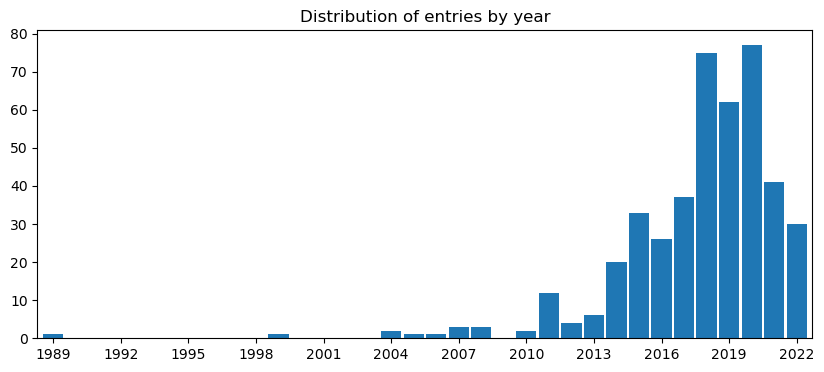

In [5]:
# Initiate
fig = plt.figure(facecolor='w',figsize=(10,4))
ax = plt.gca()

# Collect data
years = df['date']
ymin,ymax = (min(years),max(years))

# Draw and style data
ax.set_title('Distribution of entries by year')
ax.bar(range(ymin,ymax+1), [len(np.where(years == year)[0]) for year in range(ymin,ymax+1)], width=.9)
ax.set_xticks([ymin+3*i for i in range((ymax-ymin)//3+1)])
ax.set_xticklabels([str(year+ymin) for year in [3*i for i in range((ymax-ymin)//3+1)]])
ax.set_xlim([ymin-.7,ymax+.7])

# Show
plt.show()

## Visualization 2
How many tags do papers have? How many papers have a particular tag? We see that papers have around 5 tags, and that most tags are associated to less than 10 papers.

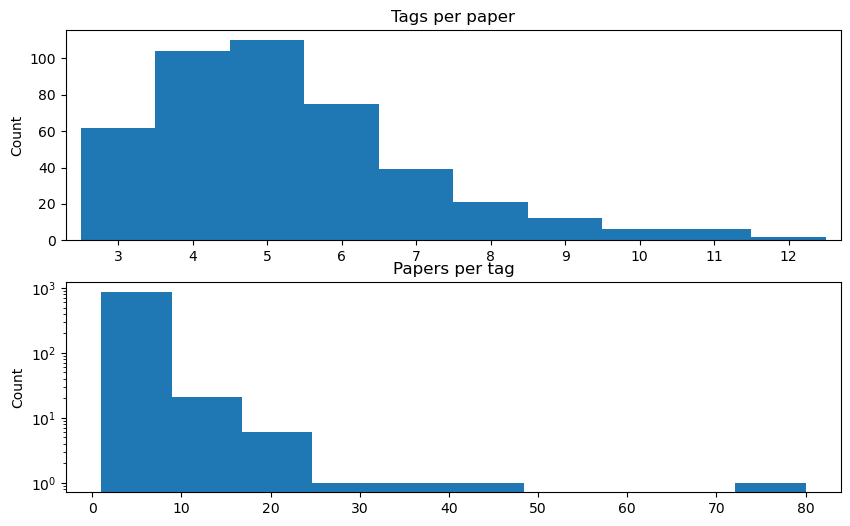

In [6]:
# Initiate
fig,axes = plt.subplots(2,1,facecolor='w',figsize=(10,6))

# Collect data, top
tag_count = np.array([len(df['tag1'][k])+len(df['tag2'][k])+len(df['tag3'][k]) for k in range(df.shape[0])])
tmin,tmax = (min(tag_count),max(tag_count))

# Draw top
ax = axes[0]
ax.set_title('Tags per paper')
ax.bar(range(tmin,tmax+1), [len(np.where(tag_count == count)[0]) for count in range(tmin,tmax+1)], width=1)
ax.set_xticks(range(tmin,tmax+1))
ax.set_xlim([tmin-.7,tmax+.7])
ax.set_ylabel('Count')

# Collect data, bottom
tags = {}
for k in range(df.shape[0]):
    for tag_list in [df['tag1'][k], df['tag2'][k], df['tag3'][k]]:
        for tag in tag_list:
            try:
                tags[tag]+=1
            except:
                tags[tag]=1
tcmin,tcmax = (min(tags.values()), max(tags.values()))
for outlier in ['2 - Persistent homology', '2 - Mapper']:
    tags.pop(outlier)

# Draw bottom
ax = axes[1]
ax.set_title('Papers per tag')
ax.hist(tags.values())
ax.set_yscale('log')
ax.set_ylabel('Count')

# Show
plt.show()

## Visualization 3
How many tags of a particular type (1,2, or 3) do papers have?

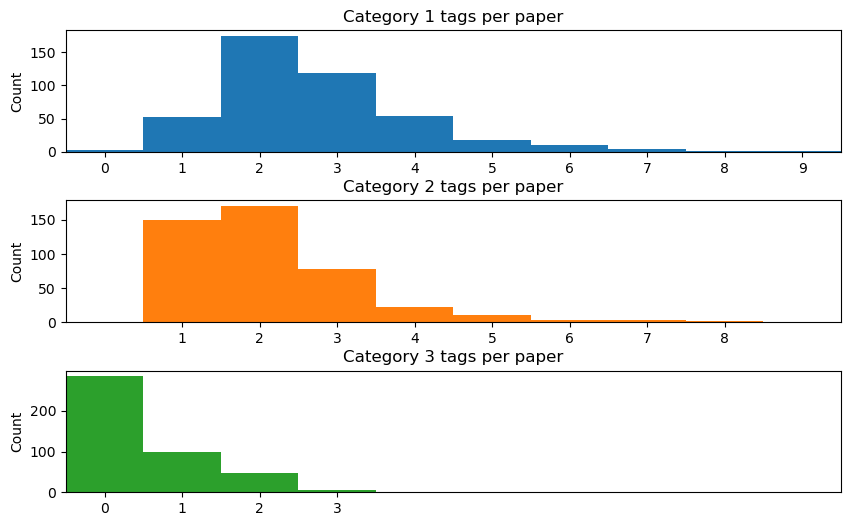

In [7]:
# Initiate
fig,axes = plt.subplots(3,1,facecolor='w',figsize=(10,6))

# Collect data, top
tag_count = np.array([len(df['tag1'][k]) for k in range(df.shape[0])])
tmin,tmax = (min(tag_count),max(tag_count))

# Draw top
ax = axes[0]
ax.set_title('Category 1 tags per paper')
ax.bar(range(tmin,tmax+1), [len(np.where(tag_count == count)[0]) for count in range(tmin,tmax+1)], width=1, color='C0')
ax.set_xticks(range(tmin,tmax+1))
ax.set_xlim([tmin-.7,tmax+.7])
ax.set_ylabel('Count')

# Collect data, middle
tag_count = np.array([len(df['tag2'][k]) for k in range(df.shape[0])])
tmin,tmax = (min(tag_count),max(tag_count))

# Draw top
ax = axes[1]
ax.set_title('Category 2 tags per paper')
ax.bar(range(tmin,tmax+1), [len(np.where(tag_count == count)[0]) for count in range(tmin,tmax+1)], width=1, color='C1')
ax.set_xticks(range(tmin,tmax+1))
ax.set_xlim([tmin-.7,tmax+.7])
ax.set_ylabel('Count')

# Collect data, bottom
tag_count = np.array([len(df['tag3'][k]) for k in range(df.shape[0])])
tmin,tmax = (min(tag_count),max(tag_count))

# Draw bottom
ax = axes[2]
ax.set_title('Category 3 tags per paper')
ax.bar(range(tmin,tmax+1), [len(np.where(tag_count == count)[0]) for count in range(tmin,tmax+1)], width=1, color='C2')
ax.set_xticks(range(tmin,tmax+1))
ax.set_xlim([tmin-.7,tmax+.7])
ax.set_ylabel('Count')

# Style
plt.subplots_adjust(hspace=.4)
for ax in axes:
    ax.set_xlim([-.5,9.5])

# Show
plt.show()

## Visualization 4
Which tags are the most popular, across all types?

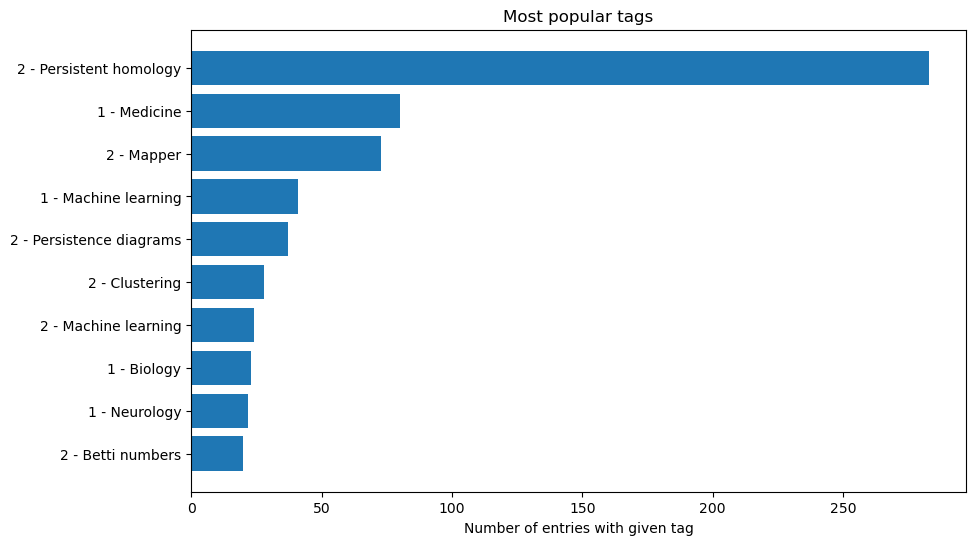

In [8]:
# Initiate
fig = plt.figure(facecolor='w',figsize=(10,6))
ax = plt.gca()

# Collect data
tags = {}
for k in range(df.shape[0]):
    for tag_list in [df['tag1'][k], df['tag2'][k], df['tag3'][k]]:
        for tag in tag_list:
            try:
                tags[tag]+=1
            except:
                tags[tag]=1
tcmin,tcmax = (min(tags.values()), max(tags.values()))
ranking = np.argsort(np.array(list(tags.values())))[::-1]
tag_names = list(tags.keys())

# Plot
topcount = 10
ax.set_title('Most popular tags')
ax.barh(range(topcount), [tags[tag_names[k]] for k in ranking[:topcount]][::-1])
ax.set_yticks(range(topcount))
ax.set_yticklabels([tag_names[k] for k in ranking[:topcount]][::-1])
ax.set_xlabel('Number of entries with given tag')

# Show
plt.show()

## Visualization 5
Which tags are the most popular, for each tag type?

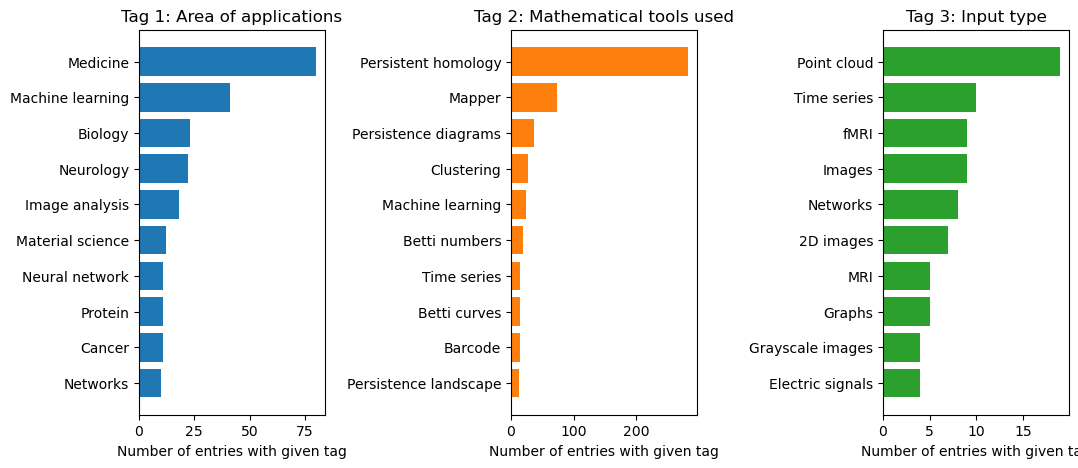

In [9]:
# Initiate
fig,axes = plt.subplots(1, 3, facecolor='w', figsize=(12,5))

# Collect data
tags = {'tag1':{}, 'tag2':{}, 'tag3':{}}
for k in range(df.shape[0]):
    for tag in df['tag1'][k]:
        try:
            tags['tag1'][tag]+=1
        except:
            tags['tag1'][tag]=1
    for tag in df['tag2'][k]:
        try:
            tags['tag2'][tag]+=1
        except:
            tags['tag2'][tag]=1
    for tag in df['tag3'][k]:
        try:
            tags['tag3'][tag]+=1
        except:
            tags['tag3'][tag]=1
ranking1 = np.argsort(np.array(list(tags['tag1'].values())))[::-1]
ranking2 = np.argsort(np.array(list(tags['tag2'].values())))[::-1]
ranking3 = np.argsort(np.array(list(tags['tag3'].values())))[::-1]
tag_names1 = list(tags['tag1'].keys())
tag_names2 = list(tags['tag2'].keys())
tag_names3 = list(tags['tag3'].keys())

# Plot
topcount = 10
for i,ax,ranking,tag_names,name,title,color in zip(
    range(3),
    axes,
    [ranking1,ranking2,ranking3],
    [tag_names1,tag_names2,tag_names3],
    ['tag1','tag2','tag3'],
    ['Area of applications', 'Mathematical tools used', 'Input type'],
    ['C0','C1','C2']
):
    ax.set_title('Tag '+str(i+1)+': '+title)
    ax.barh(range(topcount), [tags[name][tag_names[k]] for k in ranking[:topcount]][::-1], color=color)
    ax.set_yticks(range(topcount))
    ax.set_yticklabels([tag_names[k][4:] for k in ranking[:topcount]][::-1])
    ax.set_xlabel('Number of entries with given tag')

# Show
plt.subplots_adjust(wspace=1)
plt.show()